In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def get_deflection_point(alpha,xi, F,l, E,I):
    
    beta = 1-alpha
    xi_ = 1-xi
    
    if xi <=alpha:
        return (1-beta**2-xi**2)*beta*xi*F*l**3/6/E/I
    else:
        return (1-alpha**2-xi_**2)*alpha*xi_*F*l**3/6/E/I

In [7]:
def get_deflection_curve(npoints, alpha, F, l, E, I):
    
    xi_vec = np.linspace(0,1,npoints,True)
    w_vec = np.empty_like(xi_vec)
    
    for i in range(npoints):
        w_vec[i] = get_deflection_point(alpha, xi_vec[i], F, l, E, I)
    
    return w_vec

### Simple example: maximum deflection of a simply supported beam ###

#### Output variable ####

The maximal deflection computed by the defleciton curve

$w(\xi) = (1-\beta^2-\xi^2) \beta \xi \frac{F l^3}{6 E I}$

where $\xi$ is the normalized $x$ coordinate and $\beta$ the point load position as a fraction along the beam


#### Parameters and unvertainties: ####

$\beta = \mathcal{N}(0.0005, 0.00002)$ - aleatory

$F = \mathcal{N}(1000, 40) \text{ N} $- aleatory

$l = 10.000 \text{ mm}$ - deterministic

$E = \mathcal{U}(0,1000)+\{8.000, 11.000\}  \text{ N mm}^{-2}$ - polymorphic

$I=80\times 10^6 \text{ mm}^4$ - deterministic

#### Propagation: ####

is done in an epistemic outerloop, for each focal set in the single epistemic variable and an aleatory inner loop, using Monte Carlo Techniques with $N=10000$

#### Results: ####

 Histograms and scatter plots for each focal set (orange and blue)

(array([1.90315885e-05, 2.47410651e-04, 1.58279378e-03, 4.81181997e-03,
       9.27155555e-03, 8.97656592e-03, 4.86574280e-03, 1.62720082e-03,
       2.88645759e-04, 2.85473828e-05]), array([ 842.11460267,  873.64113547,  905.16766827,  936.69420107,
        968.22073387,  999.74726667, 1031.27379947, 1062.80033227,
       1094.32686507, 1125.85339787, 1157.37993067]))


<IPython.core.display.Javascript object>


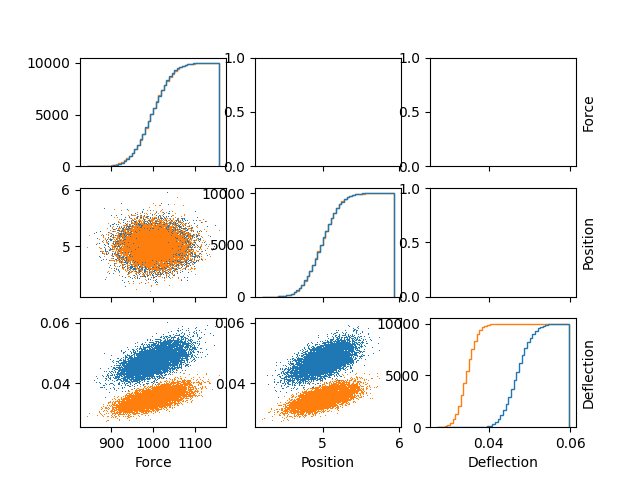

In [8]:
npoints = 25
alpha=.25
F=1000
l=10000
E=11000
I=80e6

nsamples = 10000


mu_F = 1000
var_F = 40
rand_vals= [[],[],[]]

for E in [8000, 11000]:
    E_vec = np.random.rand(nsamples)*1000+E
    F_vec = np.random.randn(nsamples)*var_F+mu_F
    a_vec = np.random.randn(nsamples)*0.2+5

    max_w_monte_carlo = np.empty_like(F_vec)

    for i in range(nsamples):

        w_curve = get_deflection_curve(npoints, a_vec[i]/l, F_vec[i], l, E_vec[i], I)
        max_w_monte_carlo[i] = max(w_curve)
    rand_vals[0].append(F_vec)
    rand_vals[1].append(a_vec)
    rand_vals[2].append(max_w_monte_carlo)
print(np.histogram(F_vec, density=True))

fig, axes = plt.subplots(3,3, sharex='col')

rand_labels = ['Force', 'Position', 'Deflection']
for i in range(3):
    axes[i,i].hist(rand_vals[i], bins=50, cumulative=True, histtype='step')
    for j in range(i):
        axes[i,j].plot(rand_vals[j][0],rand_vals[i][0], ls='none',marker=',')
        axes[i,j].plot(rand_vals[j][1],rand_vals[i][1], ls='none',marker=',')
    axes[-1,i].set_xlabel(rand_labels[i])
    axes[i,-1].yaxis.set_label_position("right")
    axes[i,-1].set_ylabel(rand_labels[i],rotation='vertical',)
plt.show()

### Verification example: analytical/numerical modal analysis ###

System: Vibrating rod, fixed-free boundaries
Input parameters and uncertainties:
- Young's modulus $E$: aleatory - e.g. due to environmental influences (temperature)
- Cross-sectional area $A$: epistemic - e.g. due to manufacturing tolerances
- Mass density $\rho$: aleatory - e.g. due to environmental influences (humidity)
- Length $L$: epistemic - e.g. due to manufacturing tolerances
- Degrees-of-freedom $n$: deterministic
- Rayleigh damping $\alpha$, $\beta$: polymorphic - aleatory due to natural material variability or environment and epistemic due to manufacturing tolerances
- (if needed additionally: boundary conditions)
    
Output parameters:
- modal frequencies: $\omega_1 \ldots \omega_? = \frac{2j-1}{2}\frac{\pi}{L}\sqrt{\frac{E}{\rho}}$
- modal damping: $\zeta_1 \ldots \zeta_? = \zeta = \frac{1}{2}\left(\frac{\alpha}{\omega}+\beta\omega\right) $
- FRF at length $x$ (also includes modeshapes) due to tip excitation: $\mathcal{H}_\mathrm{a}(\omega_\mathrm{f}) = \phi_j(x)\sum_j \frac{-\omega_j^2}{\kappa_j \left(1 + 2.0 i\zeta\frac{\omega_\mathrm{f}}{\omega_j}   - \left(\frac{\omega_\mathrm{f}}{\omega_j}\right)^{2} \right)} $
with $\phi_j(x) = \sin{\left(\frac{2j-1}{2} \frac{\pi}{L} x\right)}$
and $\kappa_j = \omega_j^2$

Proposed method: Second-Order Probability Analysis, two-stage Monte-Carlo Method with Cartesian input mass construction
- three approaches:
    - inner loop epistemic and outer loop aleatory (prefered)
    - inner loop aleatory and outer loop epistemic
    - threefold loops (either way)
    
Steps:
- define input mass and/or probability density functions
- define propagation function
- outer MCS loop: sample aleatory variables according to PDF
    - possibly compute parts of the output, which depend only on aleatory parameters
    - inner MCS loop: 
        - sample epistemic variables according to uniform distribution / regularly spaces?
        - compute output quantities (with aleatory and epistemic parameters)
    - find and store minima and maxima of outputs (could also be done in the inner loop, but better control is possible when precomputing results and postprocessing)
- draw histograms or minima and maxima

In [10]:
def mapping_function(E,A,rho,L,alpha,beta,fs,N,x):
    nyq_omega = fs / 2 * 2 * np.pi
    num_modes_ = int((nyq_omega * L / np.pi / np.sqrt(E / rho) * 2 + 1) // 2)
    
    j = np.arange(1, num_modes + 1, 1)    
    omegans = (2 * j - 1) / 2 * np.pi / L * np.sqrt(E / rho)
    zetas = 0.5 * (alpha / omegans + beta * omegans)
    
    omegas = np.fft.fftfreq(N, 1 / fs) * 2 * np.pi
    frf = np.zeros((N, ), dtype=complex)
    for mode in range(num_modes):
        omegan = omegans[mode]
        kappa = omegan**2
        modal_coordinate = np.abs(np.sin((2 * (mode + 1) - 1) / 2 * np.pi / L * x))
        frf += -omegan**2 / (kappa * (1 + 2 * 1j * zeta * omegas / omegan - (omegas / omegan)**2)) * modal_coordinate
        
    return omegans, zetas, frf    

epistemic parameters -> mass functions:
 - are a number of (focal) sets with associated degrees of belief
 - in the continuous case, sets become intervals or alike functionals defining a range of values, where each value is equally likely to be the "true" value
 - if different degrees of belief are assigned to sub-intervals, multiple subintervals must be defined
 
 - functional: $X \mapsto m$
   - where $X$ is a set or a functional defining a set of numbers, interval, etc. and assigned a mass value $m$ the total mass is assigned to a all $X$ and the remaining to $\Omega$
   
 - sampling: $m \mapsto X$ (select a set $X$ and the corresponding mass $m$)
   - sampling must be thought differently, since we define each focal sets with the intention of using that information,we should not disregard it again by not selecting it in a sampling process, then we could have "asked less experts"
   
 - propagation: 
   - we may choose to:
       - loop over focal sets individually to propagate individual expert knowledge to the output or 
       - combine all focal sets into a (possibly lower) number of new focal sets prior to propagation
   - for each focal set in X:
     - propagate each element in the focal set to $Y$ (or estimate a continuous functional defining $Y$ (e.g. an interval))
     - assign $m_X = m_Y$
     - a mass function: $Y \mapsto m_Y$ is obtained and can be plotted, e.g. as intervals at their respective mass levels
   - multiple inputs $(X_1, X_2, ...) \mapsto Y$:
     - in fuzzy-type mass functions we can define an $\alpha$-level and sample $X_1$, $X_2$, $\ldots$ at their $\alpha$-levels then assign that $\alpha$-level to $Y$
     - for general MassFunctions, all combinations of input focal sets must be computed (Cartesian Product Propagation) $A\times B = \{(a,b)\mid a \in A \ \mbox{ and } \ b \in B\}$
       - therefore the number of focal sets for each input should be kept as low ass possible ("ask only 1 to 3 experts")
       - the mass of the results will be product of the masses of input focal sets 
    - for continuous input focal sets, i.e. intervals, continuous output focal sets are assumed -> interval optimization
      - an interval optimization is approximated by Monte Carlo Techniques due to:
        - possibly noise mapping functions
        - multiple outputs
        - multidimensional outputs, that are not directly comparable
        - guaranteed convergence in a limited amount of time
        - the qualitative effect of epistemic uncertainties is more of interest than a highest possible precision of uncertainty propagatio
       - since we assume no value is more or less likely in an input interval, we propagate that assumption to the output intervals, even though the mapping function might lead to different distributions of output values
       - input intervals will be sampled by random distributions to avoid effects related to non-independentness or regular spacing of inputs
         - in order to capture best the behaviour at the interval boundaries an appropriate sampling distribution should be chosen i.e. uniform, arcsine or U-quadratic distribution
    

 - should a class be defined similar to pyds's MassFunction()? What could be the purposes:
   - definition, combination, sampling,
   - properties such as frame, core, bel, pl, q, focal, singletons, 
   - transformations: pignistic, normalize, inverse pignistic (defining a mass function from samples)
   - an appropriate way to store them in an xarray must be designed

    
aleatory parameters -> random variables, defined by a PDF/PMF type and parameters
 - these are methods of the 'np.random.rng' Class
 - mass functions are PDFs if their focal sets consist of only singletons and $\sum m_i =1$
    
 - functional: 
   - $x \mapsto p$ (defined for every $p \in [0,1]$)
   
 - sampling (using the inverse): 
   - $p \mapsto x$ (where $p$ is a randomly selected number from $[0,1]$)
   
 - propagation: 
   - analytical through the mapping function, usually impossible
   - approximation by Monte Carlo Techniques -> sample $N$ values from the distribution and propagate them
   - through the mapping function -> compute the relevant statistics/Parameters of PDFs from the output samples

difference:
 - "PMFs/PDFs assign beliefs to singletons/continuous values where MassFunctions assign beliefs to sets/intervals"

polymorphic parameters -> part of the uncertainty is due to natural variablity and another part due to insufficient knowledge
 - sampling and propagation must take part in the order of the nesting of aleatory and epistemic components
 - in the worst case a threefold nested loop will be required, where only in the innermost loop the full parameter set for the deterministic mapping function will be available, e.g.
   - aleatory (MCS) -> epistemic (interval optimization / MCS) -> aleatory (MCS)
   - epistemic (interval optimization / MCS) -> aleatory (MCS) -> epistemic (interval optimization / MCS)

 - epistemically uncertain random variables: 
   - the parameter is distributed randomly according to PMF/PDF with parameters x to a certain degree of belief y
   - parameters are defined by mass functions

   - functional:
     - $X \mapsto m$ for all $X \in \Omega$
     - $x \mapsto p$ for all $x \in X$
     
   - sampling:
     - sample parameter(s) from mass function(s)
     - build PDF/PMF
     - sample value vom PDF/PMF

   - propagation:
     - for each focal set:
       - for each value in focal set / interval optimization: (i.o. -> find the values from the focal set that maximize and minize the output)
         - build PMF/PDF
         - for $n_a$ in $N_a$ (Monte Carlo Sampling): 
           - sample value from PMF/PDF
           - propagate through mapping function $Y$
         - compute statistics of interest (mean, var, min, max, other)
       - build output focal set from collected statistics and assign the respective mass to it

 - randomly defined mass functions: 
   - the parameters of a mass function are Random Variables, e.g. the interval boundaries are RVs

   - functional:
     - $X \mapsto p$ for all $X \in \Omega$ ?
     - $x \mapsto m$ for all $x \in X$

   - sampling:
     - sample parameter(s) x from RandomVariable(s) X
     - build focal set and assign a mass to it (how to choose this mass?)
     - sample value from focal set

   - propagation:
     - for $n_a$ in $N_a$ (Monte Carlo Sampling):
       - sample parameters from RandomVariables
       - build focal set and assign a mass to it (how to choose this mass?)
       - for each value in focal set / interval optimization:
         - propagate through mapping function $Y$
       - build output focal set from output values and assign the respective mass to it
     - compute statistics over the focal sets, e.g. histograms of interval boundaries (masses act as weights?)                
     
distinguish:

probability space: $(\Omega, \Sigma, P)$ (define the set of all values, the set of all subset (or continuous intervals) of all values, and a probability measure)

Random Variable: $X: \Omega \mapsto \mathbb{R}$ (picks a single value fom $\Omega$)

Probability measure: $P_X: \mathcal{B}(\mathbb{R}) \mapsto [0,1]: I \mapsto P_X(I) = P(X^{-1}[I])$ (assign each element/set in $\Sigma = \mathcal{B}(\mathbb{R})$ (?) a number in $[0,1]$)

Probability density function: $P_X(I) = \int_I f_X(t)d(t)$ (actually $f_X$ is the pdf )

the types of polymorphy and the structure of the mapping function should be adapted to minimize computational cost,
e.g. parts of the mapping function may be propagated in one of the outer loops and only the final steps are performed
in the innermost loop

                        
from a programming POV it might make sense to define each parameter as an object MassFunction or UncertainVariable


In [12]:
'''
Notation:
RVs use ('type of distribution', *(parameters,)), where parameters may also be (['a','b','yz'],) for a random set
MassFunction may contain either discrete sets, discrete intervals or continuous intervals and corresponding mass values
    we assume the type of elements is constant for all focal sets
Parameters: [(m_j, boundaries or elements), ... ] 
The type of focal set would be infered from the second argument:
    boundaries: list or tuple (2 items) for intervals, infering continuous/discrete from the dtype
    elements: set() for discrete sets
PolyMorphic: nested either: RV -> MassFunction / MassFunction -> RV
    epistemic interval defined by Random Variables:
     [(m_j, [('type of distribution a', *(parameters,)), ('type of distribution b', *(parameters,))]), ...]
    epistemic set defined by RandomVariables (that does not really make sense):
     [(m_j, {('type of distribution a', *(parameters,)), ('type of distribution b', *(parameters,)), ...}), ...]
    aleatory RV defined by MassFunction:
     ('type of distribution', *([(m^a_j, boundaries or elements), ... ], [(m^b_j, boundaries or elements), ... ]))
     
     
define stages of the mapping function which can be evaluated consecutively
instantiate all UncertainVariables and assign a mapping function stage to them



query the types and hierarchy of uncertainties to decide how many loops may be needed 
(or go for three loops anyway with possibly empty loops)
try to build the CartesianProduct of epistemic indices


A = RV() -  aleatory
B = FS() - epistemic
CC = RV(FS()) - polymorphic Type I, random variable defined by a focal set
#DD = FS(RV()) -  polymorphic Type II, focal set defined by a random variable

(a,b,c) \mapsto y


S_x = Cartesian product of B and CC
for (m_x, s_x) in S_x:
    for (b, CC) in the cartesian product of the elements of the sets in s_x:
    for (b, CC) in N_e samples of an assumed distribution of B and CC: (interval optimization approximation)
        C = RV(CC)
        for n_a in N_a:
            a = sample A
            c = sample C
            yy = func(a, b, c)
        y = statistic(yy)
    YY = [min(yy), max(yy)] or {y_1, y_2, ...}
    m_y = m_x
YY = {m_y: YYY}


'''


[([0.1, 7], 0.35), ([1, 2], 0.1)]

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


In [87]:
def deterministic_mapping(q1,q2,sigma_max=260):
    return (189/500*q1+3*q2)*16/3>sigma_max
N_mcs = int(1e6)

In [88]:
#a)
m_q1 = 15
s_q1 = 4
m_q2 = 8
s_q2 = 2
F_q1 = scipy.stats.norm(m_q1, s_q1)
F_q2 = scipy.stats.norm(m_q2, s_q2)

res = deterministic_mapping(F_q1.rvs(N_mcs),F_q2.rvs(N_mcs))
Pf = np.sum(res)/N_mcs
display(f'{Pf*1000} x 10^-3')

'1.0790000000000002 x 10^-3'

In [122]:
#b) fuzzy random variable

# definition of fuzzy distribution parameters
m_q1 = [14.6, 15.0, 15.5]
s_q1 = [3.9, 4.0, 4.06]

m_q2 = [7.4, 8.0, 8.4]
s_q2 = [1.92, 2.0, 2.11]

Pf = [1,None,0]

# alpha = 1 (fuzzy singleton)          
F_q1=scipy.stats.norm(m_q1[1],s_q1[1])
F_q2=scipy.stats.norm(m_q2[1],s_q2[1])
res = deterministic_mapping(F_q1.rvs(N_mcs),F_q2.rvs(N_mcs))
Pf[1] = np.sum(res)/N_mcs

# interval optimization by naive full factorial assuming minimax will occure at the boundaries
for boundary_q1 in [0,2]:    
    Dm_q1_ = m_q1[boundary_q1] - m_q1[1]
    Ds_q1_ = abs(s_q1[boundary_q1] - s_q1[1])
    DF_q1 = scipy.stats.norm(Dm_q1_, Ds_q1_)
    #F_q1=scipy.stats.norm(m_q1[boundary_q1],s_q1[boundary_q1])
    for boundary_q2 in [0,2]:
        
        Dm_q2_ = m_q2[boundary_q2] - m_q2[1]
        Ds_q2_ = abs(s_q2[boundary_q2] - s_q2[1])
        DF_q2 = scipy.stats.norm(Dm_q2_, Ds_q2_)
        #F_q2=scipy.stats.norm(m_q2[boundary_q2],s_q2[boundary_q2])
        
        RVs_q1 = F_q1.rvs(N_mcs)+DF_q1.rvs(N_mcs)
        RVs_q2 = F_q2.rvs(N_mcs)+DF_q2.rvs(N_mcs)
        res = deterministic_mapping(RVs_q1,RVs_q2)
        Pf_ = np.sum(res)/N_mcs
        if Pf_ < Pf[0]:
            Pf[0] = Pf_ 
#             print(f'min {boundary_q1},{boundary_q2}')
        if Pf_ > Pf[2]:
            Pf[2] = Pf_
#             print(f'max {boundary_q1},{boundary_q2}')
display([p*10000 for p in Pf])
            
# interval optimization approximation with MCS
Pf[0] = 1
Pf[2] = 0

# definition of delta fuzzy distribution parameters
m_q1 = [-0.4, 15.0, 0.5]
s_q1 = [0.06, 4.0, 0.1]

m_q2 = [-0.6, 8.0, 0.4]
s_q2 = [0.08, 2.0, 0.11]

DM_q1 = scipy.stats.uniform(m_q1[0], m_q1[2] - m_q1[0])
DS_q1 = scipy.stats.uniform(s_q1[0], s_q1[2] - s_q1[0])

DM_q2 = scipy.stats.uniform(m_q2[0], m_q2[2] - m_q2[0])
DS_q2 = scipy.stats.uniform(s_q2[0], s_q2[2] - s_q2[0])

for n in range(100):
    if not n%100: print('.', end='', flush=True)
    Dm_q1_ = DM_q1.rvs(1)
    Ds_q1_ = DS_q1.rvs(1)
    Dm_q2_ = DM_q2.rvs(1)
    Ds_q2_ = DS_q2.rvs(1)
    
    #stochastic analysis (vectorized)
    DF_q1 = scipy.stats.norm(Dm_q1_, Ds_q1_)
    DF_q2 = scipy.stats.norm(Dm_q2_, Ds_q2_)
    RVs_q1 = F_q1.rvs(N_mcs) + DF_q1.rvs(N_mcs)
    RVs_q2 = F_q2.rvs(N_mcs) + DF_q2.rvs(N_mcs)
    res = deterministic_mapping(RVs_q1,RVs_q2)
    Pf_ = np.sum(res)/N_mcs
    
    if Pf_ < Pf[0]:
        Pf[0] = Pf_
        m_q1[0] = Dm_q1_
        s_q1[0] = Ds_q1_
        m_q2[0] = Dm_q2_
        s_q2[0] = Ds_q2_
    if Pf_ > Pf[2]:
        Pf[2] = Pf_
        m_q1[2] = Dm_q1_
        s_q1[2] = Ds_q1_
        m_q2[2] = Dm_q2_
        s_q2[2] = Ds_q2_
display([p*10000 for p in Pf])
display(m_q1)
display(s_q1)
display(m_q2)
display(s_q2)



[3.2600000000000002, 10.34, 21.87]

.

[3.5300000000000002, 10.34, 19.24]

[array([-0.39590071]), 15.0, array([-0.06439861])]

[array([0.09309852]), 4.0, array([0.07859269])]

[array([-0.55804626]), 8.0, array([0.39836689])]

[array([0.08666389]), 2.0, array([0.09031355])]

In [112]:
DM_q1 = scipy.stats.uniform(-0.6,1)
rvs=DM_q1.rvs(10000)
rvs.min(), rvs.max(),DM_q1.support()

(-0.5999878224369737, 0.3999584786310255, (-0.6, 0.4))

0.000338 0
0.0002 0
0.002169 2
0.003341 2


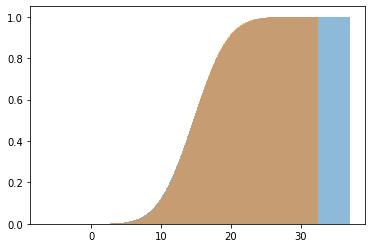

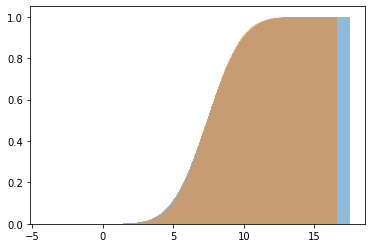

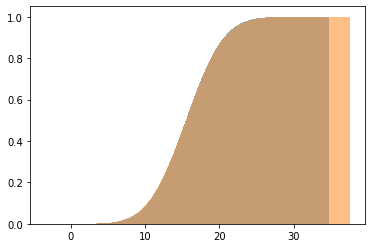

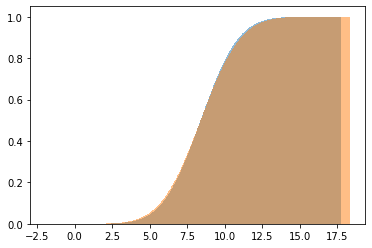

In [93]:
m_q1 = [14.6, 15.0, 15.5]
s_q1 = [3.9, 4.0, 4.06]

m_q2 = [7.4, 8.0, 8.4]
s_q2 = [1.92, 2.0, 2.11]

F_q1 = scipy.stats.norm(m_q1[1], s_q1[1])
F_q2 = scipy.stats.norm(m_q2[1], s_q2[1])

for i in [0,2]:
    m_q1_ = m_q1[i] - m_q1[1]
    s_q1_ = abs(s_q1[i] - s_q1[1])
    m_q2_ = m_q2[i] - m_q2[1]
    s_q2_ = abs(s_q2[i] - s_q2[1])
    DF_q1 = scipy.stats.norm(m_q1_, s_q1_)
    DF_q2 = scipy.stats.norm(m_q2_, s_q2_)
    RVs_q1 = F_q1.rvs(N_mcs)+DF_q1.rvs(N_mcs)
    RVs_q2 = F_q2.rvs(N_mcs)+DF_q2.rvs(N_mcs)
    res = deterministic_mapping(RVs_q1,RVs_q2)
    Pf_ = np.sum(res)/N_mcs
    print(Pf_, i)
    
    F_q1_ = scipy.stats.norm(m_q1[i], s_q1[i])
    F_q2_ = scipy.stats.norm(m_q2[i], s_q2[i])
    RVs_q1_ = F_q1_.rvs(N_mcs)
    RVs_q2_ = F_q2_.rvs(N_mcs)
    res = deterministic_mapping(RVs_q1_,RVs_q2_)
    Pf_ = np.sum(res)/N_mcs
    print(Pf_, i)

    plt.figure()
    plt.hist(RVs_q1, cumulative=True, alpha=0.5, bins=1000, density=True)
    plt.hist(RVs_q1_, cumulative=True, alpha=0.5, bins=1000, density=True)
    plt.figure()
    plt.hist(RVs_q2, cumulative=True, alpha=0.5, bins=1000, density=True)
    plt.hist(RVs_q2_, cumulative=True, alpha=0.5, bins=1000, density=True)